## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

import tensorflow as tf

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re, os

from wordcloud import WordCloud, STOPWORDS

%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Reading and analyzing dataset

In [3]:
link='/content/drive/MyDrive/training.1600000.processed.noemoticon.csv'
data=pd.read_csv(link, encoding='latin')
data.columns=['target','id', 'date', 'query', 'username', 'content']
data.head()

,target,id,date,query,username,content
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
data['target'].unique()

array([0, 4])

0: For negative tweet

4: For positive tweet.

Looking at missing values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1599999 non-null  int64 
 1   id        1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   content   1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


No null values present

Negative tweets

In [6]:
data[data['target']==0]['content'].sample(n=5)

108026    @goodandbroken89 lol yeah you were talking to ...
699266    Looking forward to visiting my bus kids today!...
471905    @Kirst_y 'Just' a cardigan? I forgot my headph...
632750    @FuneralSongs im not home :| im at kims and he...
746924    @libbyhenderson Haven't had lunch yet. Feeling...
Name: content, dtype: object

Positive tweets

In [7]:
data[data['target']==4]['content'].sample(n=5)

1259290    @frashy besides they are talented and have a g...
1045028    @Kathyireland if you feel like it this has hel...
1061911    You know you make a good burger when you burp ...
840919     @HawaiiRealty http://twitpic.com/3m0l8 {***JEA...
1267600    Photovia peacelovekaos) heâs gorgeous.  http...
Name: content, dtype: object

In [8]:
data['target']=data['target'].replace([0,4], ['Negative', 'Positive'])
data.sample(n=5)

,target,id,date,query,username,content
921993,Positive,1754308862,Sun May 10 05:48:44 PDT 2009,NO_QUERY,Siany89xx,Having a chillaxing day!! x
975325,Positive,1833506254,Sun May 17 23:30:22 PDT 2009,NO_QUERY,BeyondTheTrailr,@swerp12 The best part of Sunday?! Thanks! ...
952411,Positive,1824447178,Sun May 17 01:25:23 PDT 2009,NO_QUERY,bexandkris,GOOD MORNING EVERYONE NICE DAY TODAY
376193,Negative,2051620581,Fri Jun 05 22:25:27 PDT 2009,NO_QUERY,adamluna,"Happy about tonight, but still pissed at dumba..."
315980,Negative,2002310797,Tue Jun 02 03:50:10 PDT 2009,NO_QUERY,JennyLocke,needs a job


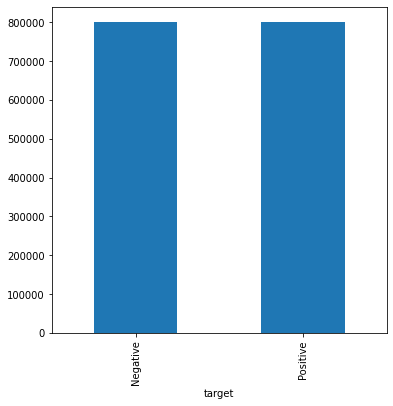

In [9]:
plt.figure(figsize=(6,6))
targets=data.groupby('target').size()
targets.plot(kind='bar')

plt.show()

In [10]:
print('Positive tweets are', len(data[data['target']=='Positive']))
print('Positive tweets are', len(data[data['target']=='Negative']))

Positive tweets are 800000
Positive tweets are 799999


Equal positive and negative tweets are almost equal

In [11]:
data['length'] = data.content.str.split().apply(len)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


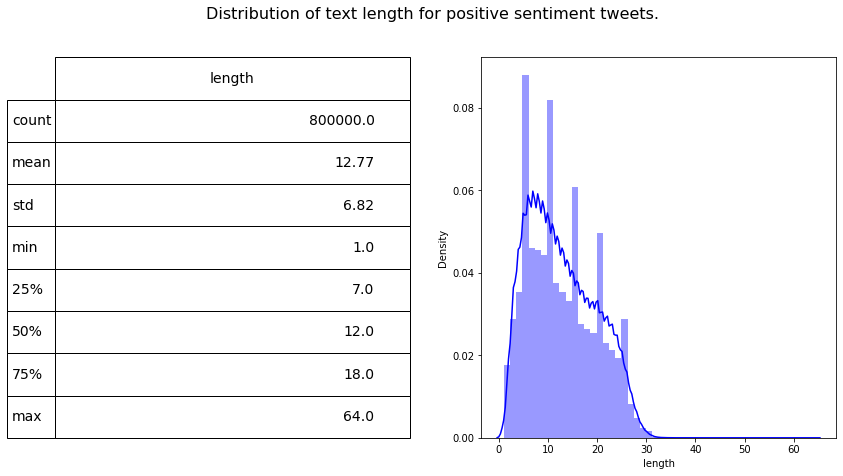

In [12]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Positive']['length'], ax=ax1,color='blue')
describe = data.length[data.target=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


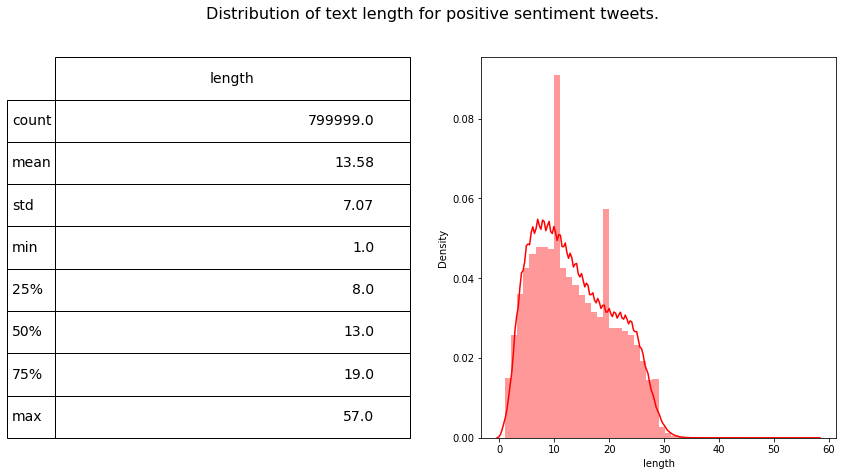

In [13]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Negative']['length'], ax=ax1,color='red')
describe = data.length[data.target=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

Distribution of tweet lengths is same in both the positive and the negative tweets but on an average the negative tweets have a higher mean than positive tweets. 

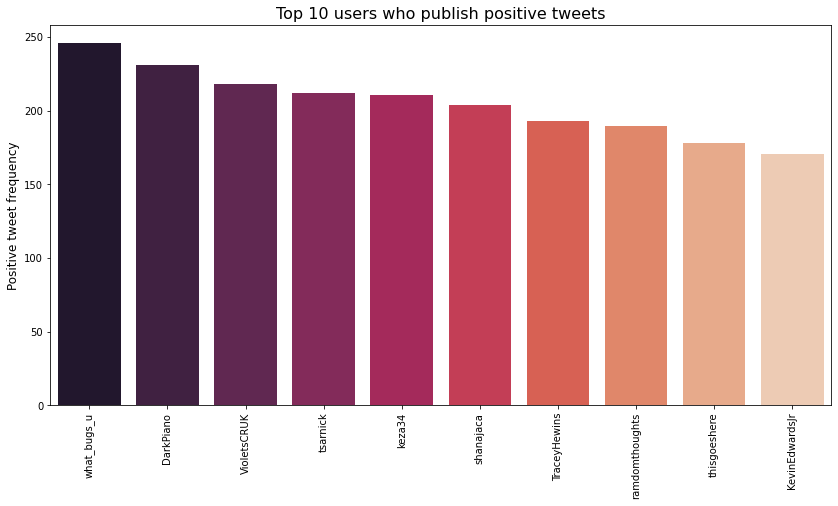

In [14]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Positive']['username'].value_counts()[:10].index, 
                           y=data[data['target']=='Positive']['username'].value_counts()[:10],palette='rocket')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Positive tweet frequency',fontsize=12)
plt.title('Top 10 users who publish positive tweets',fontsize=16)
plt.show()

People who are spreading positive vibes. what_bugs_u tweeted the most

In [15]:
data[data['username']=='what_bugs_u'].head()

,target,id,date,query,username,content,length
1141440,Positive,1977182027,Sat May 30 20:18:46 PDT 2009,NO_QUERY,what_bugs_u,@JadeMcCray why limit your story to 140 chr. T...,22
1141625,Positive,1977198277,Sat May 30 20:21:22 PDT 2009,NO_QUERY,what_bugs_u,@cadmiumcannibal why limit your story to 140 c...,22
1141647,Positive,1977207353,Sat May 30 20:22:52 PDT 2009,NO_QUERY,what_bugs_u,@RonanDosSantos why limit your story to 140 ch...,22
1141673,Positive,1977208245,Sat May 30 20:23:01 PDT 2009,NO_QUERY,what_bugs_u,@ShayMac28 why limit your story to 140 chr. Te...,22
1142666,Positive,1977331498,Sat May 30 20:43:12 PDT 2009,NO_QUERY,what_bugs_u,@lynnsdecor why limit your story to 140 chr. T...,22


In [16]:
data[data['username']=='what_bugs_u'].sample(n=10)

,target,id,date,query,username,content,length
1266090,Positive,1999571947,Mon Jun 01 20:27:09 PDT 2009,NO_QUERY,what_bugs_u,@EighthHorcrux why limit your story to 140 ch....,22
1440251,Positive,2061636406,Sat Jun 06 21:17:08 PDT 2009,NO_QUERY,what_bugs_u,@gracieh89 why limit your story to 140 ch. Tel...,16
1337822,Positive,2017838725,Wed Jun 03 09:01:51 PDT 2009,NO_QUERY,what_bugs_u,@mslauren2930 why limit your story to 140 ch....,22
1224487,Positive,1990552391,Mon Jun 01 05:10:04 PDT 2009,NO_QUERY,what_bugs_u,@Henre why limit your story to 140 ch. Tell al...,22
1297444,Positive,2004532207,Tue Jun 02 08:20:50 PDT 2009,NO_QUERY,what_bugs_u,@berryliciouz why limit your story to 140 ch. ...,22
1346346,Positive,2044289239,Fri Jun 05 09:08:30 PDT 2009,NO_QUERY,what_bugs_u,@poptartnoise why limit your story to 140 ch. ...,16
1330678,Positive,2015859401,Wed Jun 03 05:40:30 PDT 2009,NO_QUERY,what_bugs_u,@CourtHarkness why limit your story to 140 ch...,22
1288656,Positive,2002512732,Tue Jun 02 04:25:49 PDT 2009,NO_QUERY,what_bugs_u,@xxxch33s3xxx3 why limit your story to 140 ch....,22
1298500,Positive,2005196739,Tue Jun 02 09:20:55 PDT 2009,NO_QUERY,what_bugs_u,@riotthyme why limit your story to 140 ch. Tel...,22
1180320,Positive,1981888146,Sun May 31 10:05:45 PDT 2009,NO_QUERY,what_bugs_u,@theglamlife why limit your story to 140 ch. T...,22


Same tweets again and and again he must be a bot.

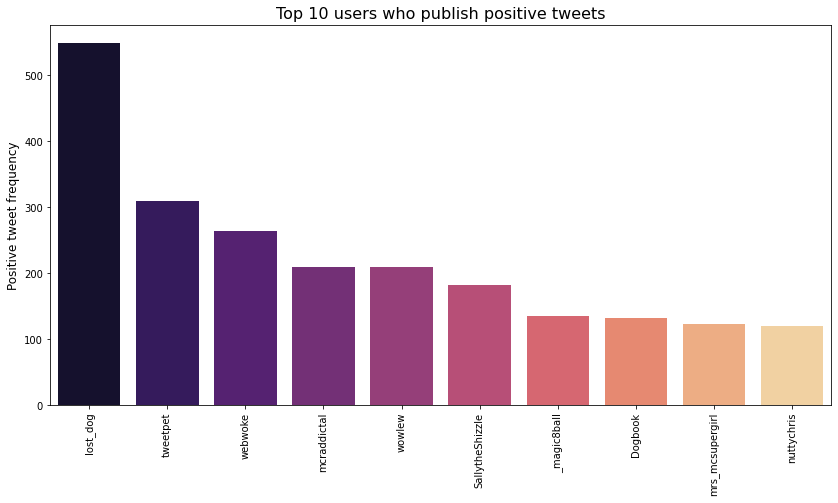

In [17]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Negative']['username'].value_counts()[:10].index, 
                           y=data[data['target']=='Negative']['username'].value_counts()[:10],palette='magma')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Positive tweet frequency',fontsize=12)
plt.title('Top 10 users who publish positive tweets',fontsize=16)
plt.show()

In [18]:
data[data['username']=='lost_dog'].head()

,target,id,date,query,username,content,length
43934,Negative,1676704158,Fri May 01 22:54:02 PDT 2009,NO_QUERY,lost_dog,@NyleW I am lost. Please help me find a good h...,11
45573,Negative,1677189389,Sat May 02 00:51:35 PDT 2009,NO_QUERY,lost_dog,@SallyD I am lost. Please help me find a good ...,11
46918,Negative,1677519173,Sat May 02 02:30:50 PDT 2009,NO_QUERY,lost_dog,@zuppaholic I am lost. Please help me find a g...,11
47948,Negative,1677752995,Sat May 02 03:47:51 PDT 2009,NO_QUERY,lost_dog,@LOSTPETUSA I am lost. Please help me find a g...,11
50571,Negative,1678544903,Sat May 02 07:02:28 PDT 2009,NO_QUERY,lost_dog,@JeanLevertHood I am lost. Please help me find...,11


In [19]:
data[data['username']=='lost_dog'].sample(n=5)

,target,id,date,query,username,content,length
283805,Negative,1993005093,Mon Jun 01 09:40:38 PDT 2009,NO_QUERY,lost_dog,@MLTNews I am lost. Please help me find a good...,11
442426,Negative,2067274801,Sun Jun 07 12:03:32 PDT 2009,NO_QUERY,lost_dog,@sylvietta89 I am lost. Please help me find a ...,11
692099,Negative,2252414522,Sat Jun 20 06:12:54 PDT 2009,NO_QUERY,lost_dog,@mischiefmuttntx I am lost. Please help me fin...,11
579042,Negative,2213335264,Wed Jun 17 15:14:17 PDT 2009,NO_QUERY,lost_dog,@debbiet I am lost. Please help me find a good...,11
601833,Negative,2221242656,Thu Jun 18 05:00:07 PDT 2009,NO_QUERY,lost_dog,@erikbruce I am lost. Please help me find a go...,11


Same tweets, it must be a bot

## Wordcloud

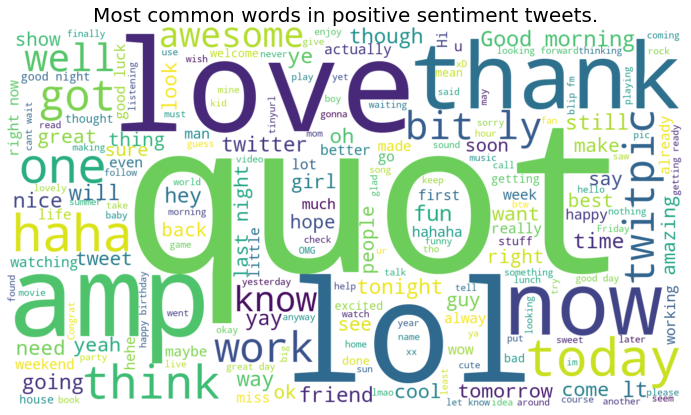

In [20]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Positive'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in positive sentiment tweets.',fontsize=20)
plt.show()

Most positive words according to wordcloud are Quot, lol, love, haha

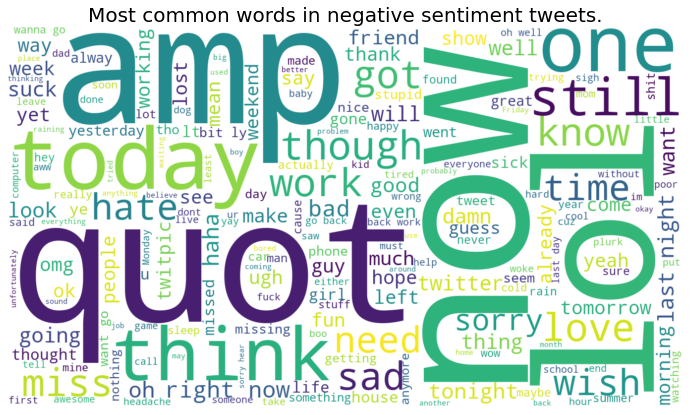

In [21]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Negative'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

Most used negative words are quot, lol amp, now.

## Data Preprocessing

In [22]:
data.drop(['id','date','query','username','length'], axis=1, inplace=True)

In [23]:
data.head()

,target,content
0,Negative,is upset that he can't update his Facebook by ...
1,Negative,@Kenichan I dived many times for the ball. Man...
2,Negative,my whole body feels itchy and like its on fire
3,Negative,"@nationwideclass no, it's not behaving at all...."
4,Negative,@Kwesidei not the whole crew


In [24]:
data.target = data.target.replace({'Positive': 1, 'Negative': 0})

In [25]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [26]:
def preprocess(content, stem=False):
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

In [27]:
data.content = data.content.apply(lambda x: preprocess(x))

In [28]:
data.head()

,target,content
0,0,upset updat facebook text might cri result sch...
1,0,dive mani time ball manag save 50 rest go bound
2,0,whole bodi feel itchi like fire
3,0,behav mad see
4,0,whole crew


## Test train split

In [29]:
train, test = train_test_split(data, test_size=0.1, random_state=44)

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.content)  
vocab_size = len(tokenizer.word_index) + 1 
max_length = 50

In [31]:
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (1439999, 2)
Test dataset shape: (160000, 2)


In [32]:
sequences_train = tokenizer.texts_to_sequences(train.content) 
sequences_test = tokenizer.texts_to_sequences(test.content) 

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.target.values
y_test = test.target.values

In [33]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_link='/content/drive/MyDrive/glove.6B.100d.txt'
glove_file = open(glove_link)

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

## Model

In [34]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

In [35]:
num_epochs = 10
batch_size = 1000

model with embeding and stacked LSTM

In [36]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

summary of model

In [45]:
len(model.layers)

7

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           26892100  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

Each layer of model

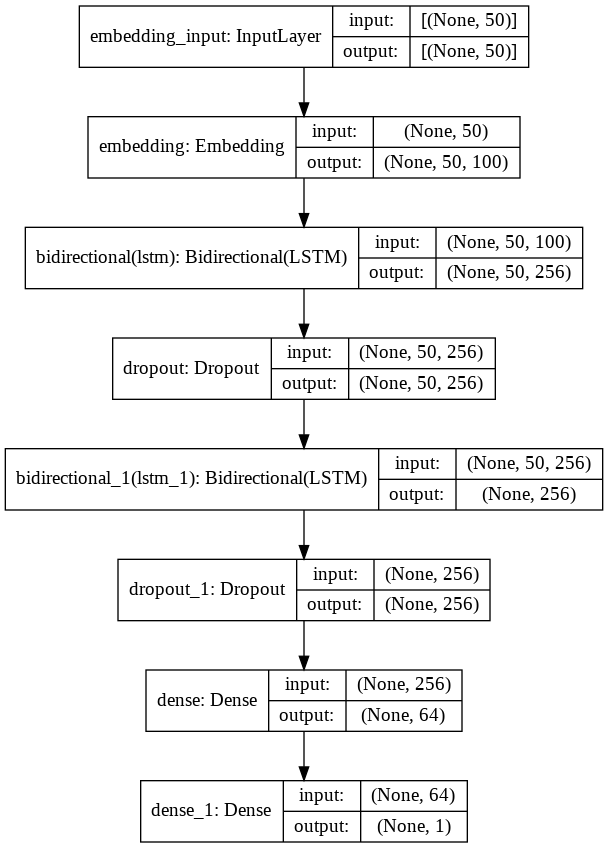

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [39]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
1440/1440 - 163s - loss: 0.5317 - accuracy: 0.7290 - val_loss: 0.5099 - val_accuracy: 0.7461
Epoch 2/10
1440/1440 - 133s - loss: 0.5016 - accuracy: 0.7514 - val_loss: 0.4953 - val_accuracy: 0.7546
Epoch 3/10
1440/1440 - 135s - loss: 0.4906 - accuracy: 0.7592 - val_loss: 0.4884 - val_accuracy: 0.7588
Epoch 4/10
1440/1440 - 135s - loss: 0.4821 - accuracy: 0.7643 - val_loss: 0.4867 - val_accuracy: 0.7593
Epoch 5/10
1440/1440 - 135s - loss: 0.4756 - accuracy: 0.7685 - val_loss: 0.4806 - val_accuracy: 0.7634
Epoch 6/10
1440/1440 - 135s - loss: 0.4694 - accuracy: 0.7723 - val_loss: 0.4789 - val_accuracy: 0.7651
Epoch 7/10
1440/1440 - 135s - loss: 0.4635 - accuracy: 0.7761 - val_loss: 0.4775 - val_accuracy: 0.7667
Epoch 8/10
1440/1440 - 135s - loss: 0.4583 - accuracy: 0.7793 - val_loss: 0.4799 - val_accuracy: 0.7658
Epoch 9/10
1440/1440 - 135s - loss: 0.4528 - accuracy: 0.7826 - val_loss: 0.4859 - val_accuracy: 0.7626
Epoch 10/10
1440/1440 - 135s - loss: 0.4474 - accuracy: 0.7856 -

In [40]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     79800
           1       0.77      0.77      0.77     80200

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000



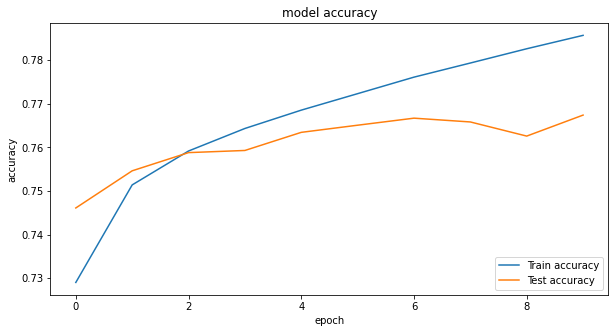

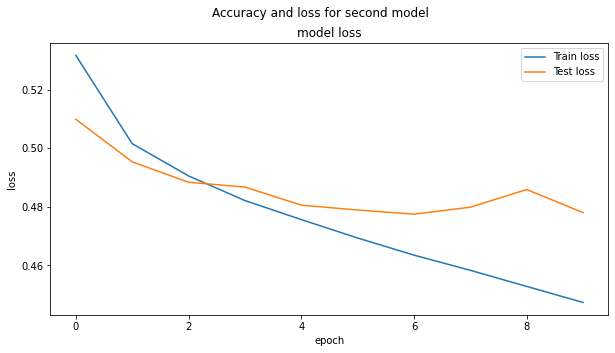

In [42]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

Conclusion :

1. Model performed good, there is some overfitting, changing reducing LR or tuning other hyper parameters should help.

2. Increasing dropout shoul also help in reducing overfitting.

3. Model has accuracy in 77% in predicting the accuracy.

